## Imports

In [3]:
import numpy as np
import scanpy as sc 
import umap
from sklearn.manifold import SpectralEmbedding
import matplotlib.pylab as plt

## Data preprocessing

### Single-cell multione gene expression

In [4]:
multiome = sc.read_h5ad("data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
gex = multiome[:, multiome.var["feature_types"] == "GEX"]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
  File "/tmp/ipykernel_28366/2653320238.py", line 1, in <module>
    multiome = sc.read_h5ad("data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
  File "/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/anndata/_io/h5ad.py", line 408, in read_h5ad
  File "/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/viktor/PythonProjects/MMML_project/venv/lib/python3.10/site-packages/h5py/_hl/files.py", line 231, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 

In [3]:
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [4]:
gex_data = gex[:, gex.var["highly_variable"]].X
gex_data.shape # should be (90k, 2500)

(90261, 2500)

In [5]:
gex_labels = gex.obs["cell_type"].values
gex_labels.shape

(90261,)

### Bank marketing dataset

In [ ]:
marketing_data = ...

## Evaluation

The evaluation pipeline is the follwoing:

1) Apply dimensionality reduction technique (Laplacian Eigenmaps, t-SNE, UMAP) to the data (application)

2) Compute quantitative metrics for the 2D embedding (KL divergence and Spearman's rank correlation) (quantitative metrics)

3) Apply Leiden clustering algorithm to the embedding and plot clusters, assess the plot qualitatively (visualization)

4) Compute ARI, AMI, Homogenuity and Completeness metrics on clustered labels to further assess the quality of the embedding (clustering metrics)


In [29]:
import sklearn.metrics as sm
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

def get_quantitative_metrics(data, embedding, eps=0.00001):
    original_distances = pdist(data, metric='euclidean') + eps
    embedded_distances = pdist(embedding, metric='euclidean') + eps
    kl_divergence = np.sum(original_distances * np.log(original_distances / embedded_distances))
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)

    print("KL Divergence:", kl_divergence)
    print("Spearman's Rank Correlation:", spearman_corr)
    return kl_divergence, spearman_corr

def plot_embedding(embedding):
    anndata = sc.AnnData(embedding)
    print(anndata.obs_keys)
    sc.pp.neighbors(anndata, use_rep="X")
    sc.tl.leiden(anndata)
    sc.tl.umap(anndata)
    leiden_labels = anndata.obs["leiden"].values
    sc.pl.umap(anndata, color="leiden")
    plt.show
    return leiden_labels

def get_clustering_metrics(labels, cluster_labels):
    ari = sm.adjusted_rand_score(labels, cluster_labels)
    ami = sm.adjusted_mutual_info_score(labels, cluster_labels)
    homogeneity = sm.homogeneity_score(labels, cluster_labels)
    completeness = sm.completeness_score(labels, cluster_labels)
    print("""
    ARI: {}\n
    AMI: {}\n
    Homogenuity: {}\n
    Completeness: {}
    """.format(ari, ami, homogeneity, completeness))
    return ari, ami, homogeneity, completeness

### t-SNE

Application

In [ ]:
def t_sne(data, n_components=2):
    embedding = ...
    return embedding

Quantitative metrics

In [ ]:
embedding = t_sne(gex_data, n_components=2)

Visualization

Clustering metrics

### Laplacian Eigenmaps

Application

In [9]:
reducer = SpectralEmbedding(n_components=2)
le_embedding = reducer.fit_transform(np.asarray(gex_data[:2000].toarray()))

In [10]:
le_embedding.shape

(2000, 2)

Quantitative metrics

In [12]:
le_kl_div, le_sp_corr = get_quantitative_metrics(np.asarray(gex_data[:2000].toarray()), le_embedding)

KL Divergence: 404454468000.7337
Spearman's Rank Correlation: 0.7549299758652686


Visualization

C:\Users\dimon\AppData\Local\Temp\ipykernel_23004\2262814147.py:16: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(embedding)


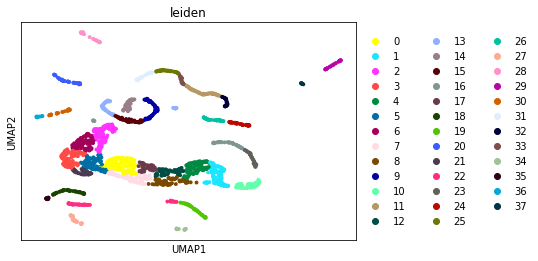

In [30]:
le_cluster_labels = plot_embedding(le_embedding)

Clustering metrics

In [32]:
le_ari, le_ami, le_homogenuity, le_completeness = get_clustering_metrics(gex_labels[:2000], le_cluster_labels)


    ARI: 0.21975694765371645

    AMI: 0.4728698504087835

    Homogenuity: 0.5672523630475469

    Completeness: 0.48271782214487824
    


In [42]:
# overall
print((le_ari + le_ami + le_homogenuity + le_completeness)/4)

0.43564924581373127


### UMAP

Application

In [34]:
reducer = umap.UMAP(n_components=2)
umap_embedding = reducer.fit_transform(gex_data[:5000])

Quantitative metrics

In [35]:
umap_kl_div, umap_sp_corr = get_quantitative_metrics(np.asarray(gex_data[:5000].toarray()), umap_embedding)

KL Divergence: 1313232499927.6465
Spearman's Rank Correlation: 0.7953632271206441


Visualization

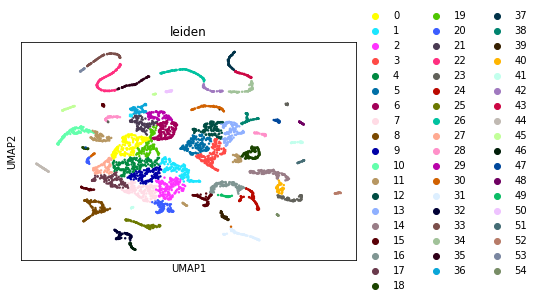

In [36]:
umap_cluster_labels = plot_embedding(umap_embedding)

Clustering metrics

In [40]:
umap_ari, umap_ami, umap_homogenuity, umap_completeness = get_clustering_metrics(gex_labels[:5000], umap_cluster_labels)


    ARI: 0.22890934884668243

    AMI: 0.5515534482377265

    Homogenuity: 0.6629262349694341

    Completeness: 0.5097989911449575
    


In [41]:
# overall
print((umap_ari + umap_ami + umap_homogenuity + umap_completeness)/4)

0.48829700579970015
